In [8]:
import torch
import numpy as np
from datagen import ImageEntity, ImageAttackPipeline, UpscaleImageTransform, create_entities
from datasets import load_dataset, create_dataloader, entity_to_dataset
from modules import NetModule, train, test

In [9]:
# loading our desired vision dataset
traindata, testdata = load_dataset('cfar10')
# turning data & labels into entities for poisoning
data, labels = traindata.data, traindata.targets
entities = create_entities(data, labels, ImageEntity)
# getting mappings for encodings to name label
mappings = {v: k for k,v in traindata.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


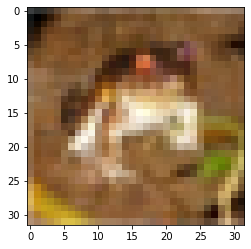

Label: frog


In [10]:
# viewing our entities
ex_entity = entities[0]
ex_entity.show()
print(f'Label: {mappings[ex_entity.get_label()]}')


In [11]:
# poisoning entities
random_state = np.random.RandomState(42)
targets = {i: i + 1 if i < 9 else 0 for i in range(len(mappings))}
transforms = [UpscaleImageTransform(scale=10)]
patch_size = (40, 40)
pipeline = ImageAttackPipeline()
clean, poisoned = pipeline.process(entities, transforms, patch_size=patch_size, targets=targets, random_state_obj=random_state)

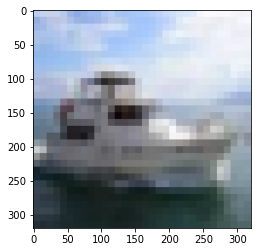

Original Label: ship


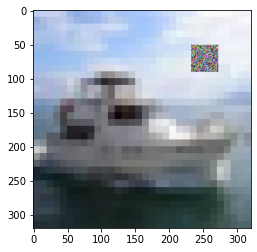

Poisoned Label: truck


In [12]:
injected = pipeline.injections
sample_injected = injected[0]
clean[sample_injected].show()
print(f'Original Label: {mappings[clean[sample_injected].get_label()]}')
poisoned[sample_injected].show()
print(f'Poisoned Label: {mappings[poisoned[sample_injected].get_label()]}')


In [7]:
cleanset = entity_to_dataset(clean)
poisonset = entity_to_dataset(poisoned)
cleantrainloader = create_dataloader(cleanset, batch_size=32, n_workers=2)
poisontrainloader = create_dataloader(poisonset, batch_size=32, n_workers=2)